<h1>Project: Hungarian Chickenpox Cases Forecasting</h1>
The goal of this project is exploring chickenpox in Hunagary and predicting next year cases.

<h3>About the data set:</h3>

link to hte dataset at UCI: https://archive.ics.uci.edu/ml/datasets/Hungarian+Chickenpox+Cases

Data Set Characteristics: Time-Series

Number of Instances: 521

Area: Life

Attribute Characteristics: Real

Number of Attributes: 20

Date Donated 2021-02-17

Associated Tasks: Regression

Missing Values? N/A

Number of Web Hits: 24976

<h3>Source:</h3>

Benedek Rozemberczki, The University of Edinburgh, benedek.rozemberczki '@' gmail.com

<h3>Data Set Information:</h3>

A spatio-temporal dataset of weekly chickenpox (childhood disease) cases from Hungary. The dataset consists of a county-level adjacency matrix and time series of the county-level reported cases between 2005 and 2015. There are 2 specific related tasks: County level case count prediction and nation level case count prediction.

<h3>Attribute Information:</h3>

Attributes are weekly counts of chickenpox cases in Hungarian counties.


<h3>Relevant Papers:</h3>

Chickenpox Cases in Hungary: a Benchmark Dataset for Spatiotemporal Signal Processing with Graph Neural Networks
Benedek Rozemberczki, Paul Scherer, Oliver Kiss, Rik Sarkar, Tamas Ferenci



<h3>Citation Request:</h3>

@misc{rozemberczki2021chickenpox,
title={Chickenpox Cases in Hungary: a Benchmark Dataset for Spatiotemporal Signal Processing with Graph Neural Networks},
author={Benedek Rozemberczki and Paul Scherer and Oliver Kiss and Rik Sarkar and Tamas Ferenci},
year={2021},
eprint={2102.08100},
archivePrefix={arXiv},
primaryClass={cs.SI}
}

## Discussion: SARIMA and LSTM demonstrared similar performance in predicting next year monthly cases of chickenpox in Hungary.

# County-wide cases prediction

<h2>1. EDA

In [1]:
# installing libraries
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# importing libraries

from platform import python_version
import warnings

# for working with arrays and dataframes
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats # for Q-Q plots

# load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
# for determining (p,q) orders
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# for ETS Plots
from statsmodels.tsa.seasonal import seasonal_decompose
# for determining ARIMA orders
from pmdarima import auto_arima
# for evaluating models
from statsmodels.tools.eval_measures import rmse

# for scaling
from sklearn.preprocessing import MinMaxScaler

# Keras time generator
from keras.preprocessing.sequence import TimeseriesGenerator
# keras libraries for model building
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# for saving weights
import joblib

In [3]:
# showing versions
print('Python version:',python_version())
print('NumPy version:',np.__version__)
print('Pandas version:',pd.__version__)
print('Joblib version:',joblib.__version__)

Python version: 3.7.14
NumPy version: 1.21.6
Pandas version: 1.3.5
Joblib version: 1.1.0


In [4]:
# settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [5]:
# importing the dataset
df = pd.read_csv("hungary_chickenpox.csv")
print(f"{df.shape[1]} columns, {df.shape[0]} rows")
# checking duplicated rows
print(f"{df.duplicated().sum()} duplicated rows")
df.head()

21 columns, 522 rows
0 duplicated rows


,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,03/01/2005,168,79,30,173,169,42,136,120,162,36,130,57,2,178,66,64,11,29,87,68
1,10/01/2005,157,60,30,92,200,53,51,70,84,28,80,50,29,141,48,29,58,53,68,26
2,17/01/2005,96,44,31,86,93,30,93,84,191,51,64,46,4,157,33,33,24,18,62,44
3,24/01/2005,163,49,43,126,46,39,52,114,107,42,63,54,14,107,66,50,25,21,43,31
4,31/01/2005,122,78,53,87,103,34,95,131,172,40,61,49,11,124,63,56,7,47,85,60


In [6]:
# setting "Date" to be the index
df.set_index('Date', inplace=True)
df.index.freq = 'W'
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')
df.head(3)

,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
Date,,,,,,,,,,,,,,,,,,,,
2005-01-03,168,79,30,173,169,42,136,120,162,36,130,57,2,178,66,64,11,29,87,68
2005-01-10,157,60,30,92,200,53,51,70,84,28,80,50,29,141,48,29,58,53,68,26
2005-01-17,96,44,31,86,93,30,93,84,191,51,64,46,4,157,33,33,24,18,62,44


In [7]:
# making a list of the variables that contain missing values
vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 0]

# determining percentage of missing values (expressed as decimals)
# and displaying the result ordered by percent of missin data

df[vars_with_na].isnull().mean().sort_values(ascending=False)

Series([], dtype: float64)

In [8]:
# summing up all the columns
df['Total_Cases'] = df.iloc[:, 1:].sum(axis = 1, skipna = True)
df.head()

,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA,Total_Cases
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,168,79,30,173,169,42,136,120,162,36,130,57,2,178,66,64,11,29,87,68,1639
2005-01-10,157,60,30,92,200,53,51,70,84,28,80,50,29,141,48,29,58,53,68,26,1250
2005-01-17,96,44,31,86,93,30,93,84,191,51,64,46,4,157,33,33,24,18,62,44,1188
2005-01-24,163,49,43,126,46,39,52,114,107,42,63,54,14,107,66,50,25,21,43,31,1092
2005-01-31,122,78,53,87,103,34,95,131,172,40,61,49,11,124,63,56,7,47,85,60,1356


<h3>Plotting the series for whole country</h3>

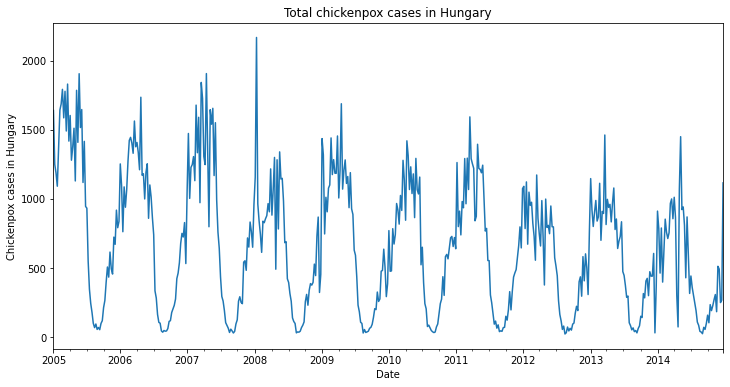

In [9]:
title = 'Total chickenpox cases in Hungary'
ylabel = 'Chickenpox cases in Hungary'
xlabel = 'Date'

ax = df['Total_Cases'].plot(figsize=(12, 6), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Discussion: the series shows downward trend and annual oscillations with fluctuations in higher areas.

In [10]:
# resampling the series monthly
df = df.resample('M').mean()

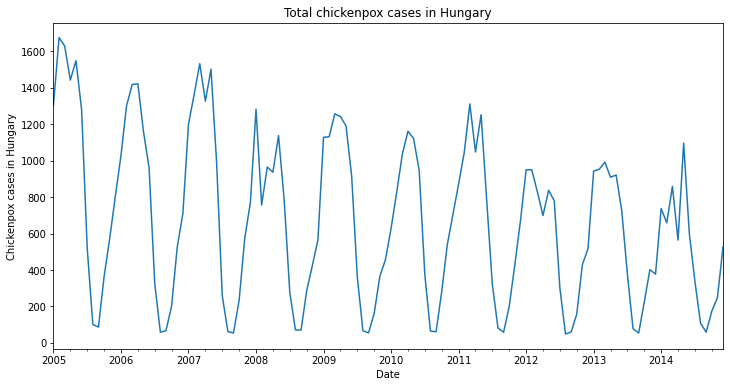

In [11]:
title = 'Total chickenpox cases in Hungary'
ylabel = 'Chickenpox cases in Hungary'
xlabel = 'Date'

ax = df['Total_Cases'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

<h3>Per-area the time series</h3>

In [12]:
# making a datades of the cases per area
df_areas = df.copy().drop(['Total_Cases'], axis=1)

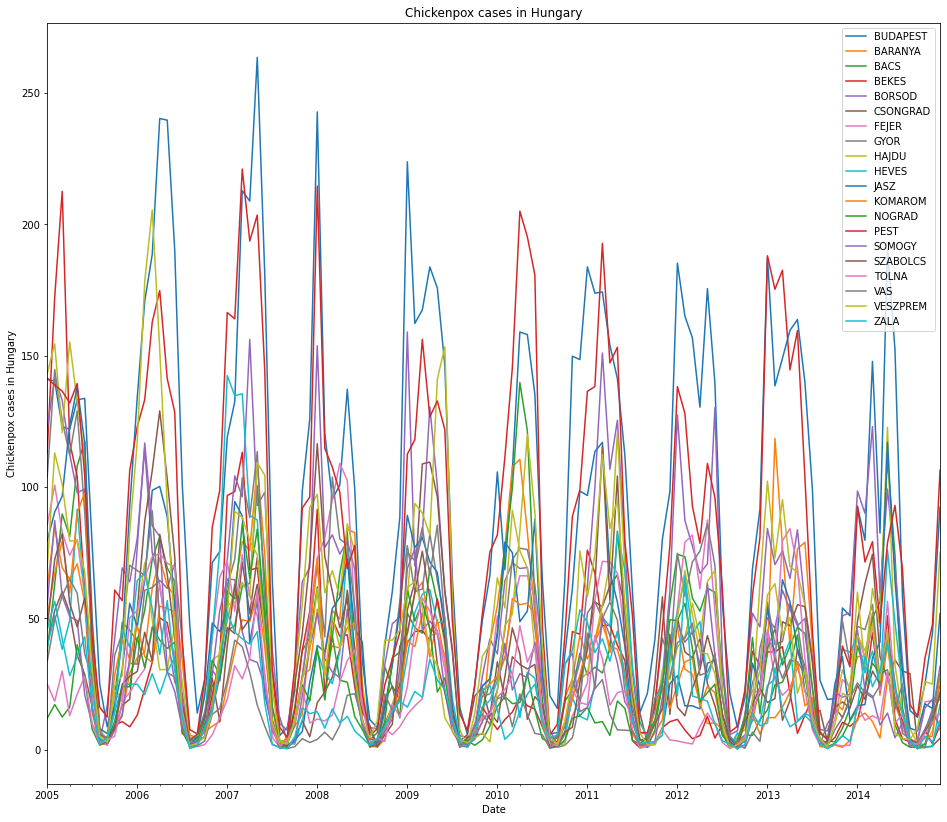

In [13]:
# plotting all the sries on the same scale
title = 'Chickenpox cases in Hungary'
ylabel = 'Chickenpox cases in Hungary'
xlabel = 'Date'

ax = df_areas.plot(figsize=(16,14), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [14]:
# calculating mean and total values per state
df_agg = pd.concat([df_areas.sum(axis=0), df_areas.mean(axis=0)], axis=1)
df_agg.columns = ['Mean','Sum']
df_agg

,Mean,Sum
BUDAPEST,12196.35,101.636250
BARANYA,4127.90,34.399167
BACS,4487.80,37.398333
BEKES,3482.05,29.017083
BORSOD,6891.90,57.432500
CSONGRAD,3807.40,31.728333
FEJER,4026.60,33.555000
GYOR,4984.45,41.537083
HAJDU,5666.45,47.220417
HEVES,3573.55,29.779583


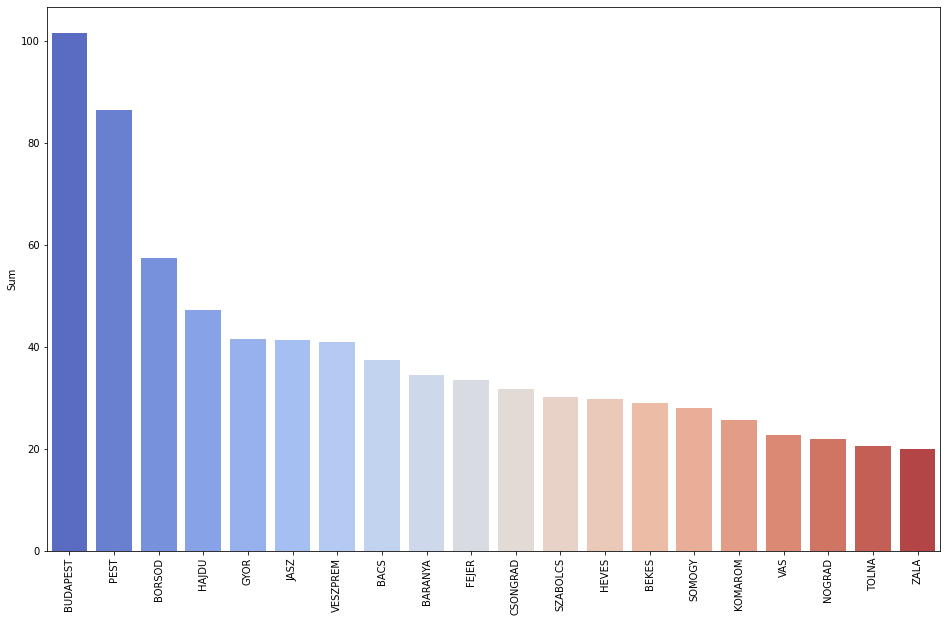

In [15]:
# plotting the cases sums per area
fig, ax = plt.subplots()
fig.set_size_inches(16,10)
ax = sns.barplot(x=df_agg.sort_values('Sum',ascending=False).index,
                 y=df_agg.sort_values('Sum',ascending=False).Sum,
                 palette='coolwarm')
plt.xticks(rotation=90);

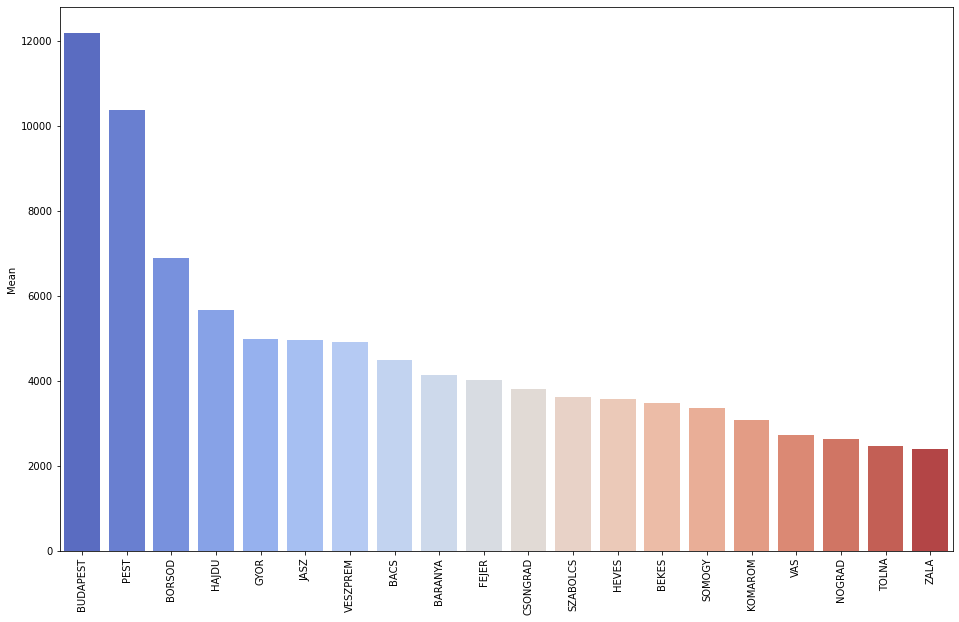

In [16]:
# plotting the cases means per area
fig, ax = plt.subplots()
fig.set_size_inches(16,10)
ax = sns.barplot(x=df_agg.sort_values('Mean',ascending=False).index,
                 y=df_agg.sort_values('Mean',ascending=False).Mean,
                 palette='coolwarm')
plt.xticks(rotation=90);

Discussion: Budapest and Pest areas cases count is prominently higher than others. Tolna and Zala shows least cases. Order of cases sum is consistent with mean for all the areas.

<h2>2. Analyzing country level time series and predicting one year with SARIMA</3>

<h3>SARIMA optimized with autoARIMA<h3>

<b>Running ETS decomposition</b>

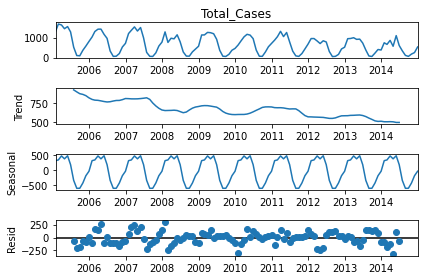

In [17]:
# decomposing the series to trend, seasonal and residual and then plotting them
result = seasonal_decompose(df['Total_Cases'], model='add')
result.plot();

Discussion: the decomposition shows a prominent seasonal component and an unclear trend.

<b>Runing pmdarima.auto_arima to obtain recommended orders</b>

In [18]:
# for SARIMA orders setting seasonal=True and pass in an m value
auto_arima(df['Total_Cases'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  120
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -772.540
Date:                              Thu, 22 Sep 2022   AIC                           1555.079
Time:                                      13:52:15   BIC                           1569.017
Sample:                                  01-31-2005   HQIC                          1560.739
                                       - 12-31-2014                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5726      5.356      1.040      0.298      -4.925      16.070
ar.L1          0.6579      0.073      9.003      0.000       0.515       0.801
ar.S.L12       0.9767      0.017     55.900      0.000       0.942       1.011
ma.S.L12      -0.6057      0.142     -4.280      0.000      -0.883      -0.328
sigma2      1.884e+04   1426.184     13.212      0.000     1.6e+04    2.16e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.43   Jarque-Bera (JB):               106.22
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.95
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This provides an ARIMA Order of (1,0,0) combined with a seasonal order of (1,0,1,12) Now let's train & test the SARIMA(1,0,0)(1,0,1,12) model, evaluate it, then produce a forecast of future values.

### Splitting the data into train/test sets

In [19]:
len(df)

120

In [20]:
# setting one year for testing
train = df.iloc[:109]
test = df.iloc[109:]

In [21]:
# fitting SARIMA(1,0,0)(1,0,1,12) model
model = SARIMAX(train['Total_Cases'], order=(1, 0, 0),
                seasonal_order=(1, 0, 1, 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          Total_Cases   No. Observations:                  109
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -701.673
Date:                              Thu, 22 Sep 2022   AIC                           1411.347
Time:                                      13:52:17   BIC                           1422.112
Sample:                                  01-31-2005   HQIC                          1415.713
                                       - 01-31-2014                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7908      0.043     18.262      0.000       0.706       0.876
ar.S.L12       0.9925      0.010     95.168      0.000       0.972       1.013
ma.S.L12      -0.7414      0.176     -4.220      0.000      -1.086      -0.397
sigma2       1.75e+04   1492.762     11.725      0.000    1.46e+04    2.04e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):               207.42
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -1.35
Prob(H) (two-sided):                  0.17   Kurtosis:                         9.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
# obtaining predicted values
start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(
    start=start, end=end, dynamic=False, typ='levels'
    ).rename('SARIMA(1,0,0)(1,0,1,12) Predictions')

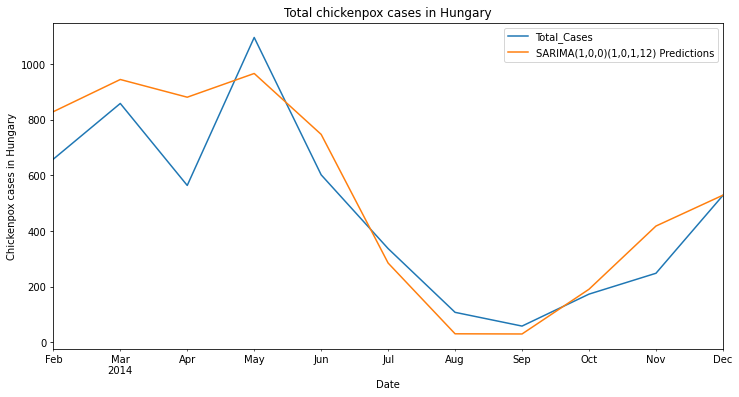

In [23]:
# plotting predictions against known values
title = 'Total chickenpox cases in Hungary'
ylabel = 'Chickenpox cases in Hungary'
xlabel = 'Date'

ax = test['Total_Cases'].plot(legend=True, figsize=(12, 6), title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

<b>Evaluating SARIMA model predictions</b>

In [24]:
error = rmse(test['Total_Cases'], predictions)
print(f"SARIMA(1,0,0)(1,0,1,12) RMSE Error: {error:.2f}")

SARIMA(1,0,0)(1,0,1,12) RMSE Error: 139.37


Discussion: the high prediction errors might be explained by the fact that the predicted year differs from two previous by two spikes, downward-facing and upward-facing, in April and May 2014.

<b>Retraining the model on the full data, and forecasting the future</b>

In [25]:
model = SARIMAX(df['Total_Cases'], order=(1, 0, 0),
                seasonal_order=(1, 0, 1, 12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels'
                        ).rename('SARIMA(1,0,0)(1,0,1,12) Forecast')

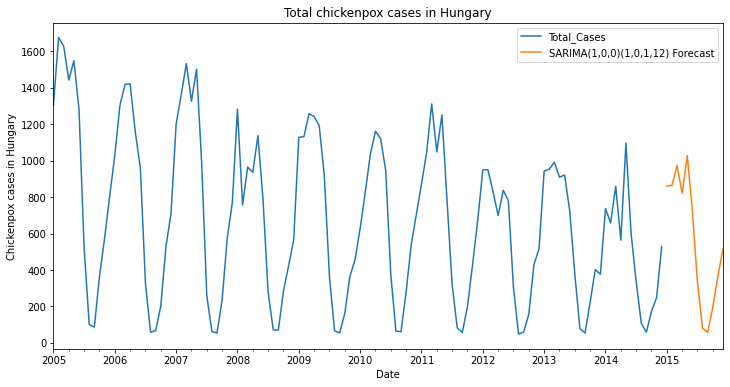

In [26]:
# plotting predictions against known values
title = 'Total chickenpox cases in Hungary'
ylabel = 'Chickenpox cases in Hungary'
xlabel = 'Date'

ax = df['Total_Cases'].plot(legend=True, figsize=(12, 6), title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### Summary: SARIMA(1,0,0)(1,0,1,12) has reasonably repeated the time series pattern after interpolating from weekly to monthly sampling.

<h3>3. Predicting country-wise cases with LSTM RNN</h3>

<b>First, predicting the test set</b>

### Scale the data

In [27]:
# creating train_total and test_total datasets only with "Total_Cases" column
area_cols = ['BUDAPEST', 'BARANYA', 'BACS', 'BEKES', 'BORSOD', 'CSONGRAD',
                   'FEJER','GYOR', 'HAJDU', 'HEVES', 'JASZ', 'KOMAROM',
                   'NOGRAD', 'PEST', 'SOMOGY', 'SZABOLCS', 'TOLNA', 'VAS',
                   'VESZPREM', 'ZALA']
train_total = train.drop(area_cols, axis = 1)
test_total = test.drop(area_cols, axis = 1)

In [28]:
# defining a scaler
scaler = MinMaxScaler()
# fitting the scaler
scaler.fit(train_total)
# scaling the series
scaled_train = scaler.transform(train_total)
scaled_test = scaler.transform(test_total)

<b>Time series senerator</b>

In [29]:
# defining time series generator with 12 steps forwqrd generating
n_input = 12
generator = TimeseriesGenerator(
    scaled_train, scaled_train, length=n_input, batch_size=1)

In [30]:
# testing the generator
# calculating first batch
X, y = generator[0]
# printing the first batch and first month prediction
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.77177085 1.         0.9709722  0.85624328 0.92167102 0.75748733
 0.28920289 0.03197665 0.02319152 0.19367225 0.32207034 0.46475196]
Predict this y: 
 [[0.6015973]]


<b>Building model</b>

In [31]:
# defining the model
n_features = 1   # for single time series
n_lstm = 120
model = Sequential()
model.add(LSTM(n_lstm, input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120)               58560     
                                                                 
 dense (Dense)               (None, 1)                 121       
                                                                 
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________


In [32]:
# fitting the model
n_epochs = 60
model.fit_generator(generator, epochs=n_epochs, verbose=0)

In [33]:
#showing the convergence log columns
model.history.history.keys()

dict_keys(['loss'])

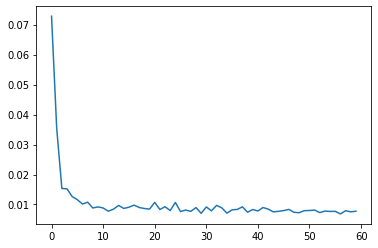

In [34]:
# printing the convergence log
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

<b>Evaluating the test data</b>

In [35]:
# first batch
first_eval_batch = scaled_train[-12:]
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
first_eval_batch

array([[[0.55552143],
        [0.57948088],
        [0.52861312],
        [0.53616956],
        [0.41560436],
        [0.20165873],
        [0.017816  ],
        [0.00310244],
        [0.10766395],
        [0.21701736],
        [0.20165873],
        [0.42313009]]])

In [36]:
# predicting first vaue of the test series
model.predict(first_eval_batch)

array([[0.47634465]], dtype=float32)

In [37]:
scaled_test[0]

array([0.37475042])

<b>Predicting into the future for the entire test range</b>

In [38]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
np.append(current_batch[:, 1:, :], [[[99]]], axis=1)
print(current_batch.shape)
current_batch

(1, 12, 1)


array([[[0.55552143],
        [0.57948088],
        [0.52861312],
        [0.53616956],
        [0.41560436],
        [0.20165873],
        [0.017816  ],
        [0.00310244],
        [0.10766395],
        [0.21701736],
        [0.20165873],
        [0.42313009]]])

In [39]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)): 
    # getting a prediction 1 time stamp ahead
    # ([0] is for taking one number instead of [array])
    current_pred = model.predict(current_batch)[0]
    # storing the prediction
    test_predictions.append(current_pred) 
    # updating batch by including prediction and dropping a first value
    current_batch = np.append(current_batch[:, 1:, :],
                              [[current_pred]], axis=1)

In [40]:
test_predictions

[array([0.47634465], dtype=float32),
 array([0.5284759], dtype=float32),
 array([0.5606101], dtype=float32),
 array([0.56711066], dtype=float32),
 array([0.48661023], dtype=float32),
 array([0.27105963], dtype=float32),
 array([0.07790318], dtype=float32),
 array([0.0170327], dtype=float32),
 array([0.05251226], dtype=float32),
 array([0.13713229], dtype=float32),
 array([0.24060416], dtype=float32)]

In [41]:
scaled_test

array([[0.37475042],
       [0.497773  ],
       [0.31669482],
       [0.64352634],
       [0.34013208],
       [0.17723852],
       [0.03639994],
       [0.0060513 ],
       [0.07663953],
       [0.1227154 ],
       [0.29467056]])

<b>Inverse transformations and comparison</b>

In [42]:
# inverse transformation
true_predictions = scaler.inverse_transform(test_predictions)
# true_predictions

In [43]:
# adding "Predictions" column to test_total
test_total['LSTM Predictions'] = true_predictions

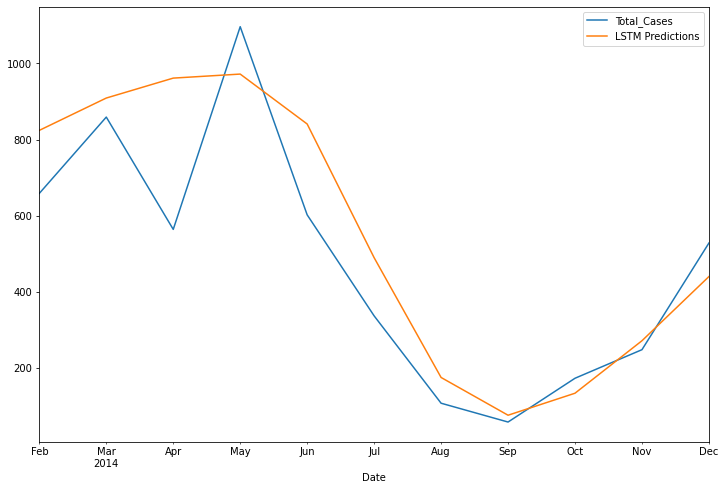

In [44]:
# plotting y & y_hat
test_total.plot(figsize=(12, 8));

<b>Evaluating LSTM model prediction</b>

In [45]:
error = rmse(test_total['Total_Cases'], test_total['LSTM Predictions'])
print(f'LSTM RMSE Error: {error:.2f}')

LSTM RMSE Error: 164.55


Discussion: LSTM error is sensible higher than SARIMA error. This might be because of the fact LSTM did not reflect abrupt fluctuations.

<b>Predicting one year forward</br>

In [46]:
# creating df_total dataset only with "Total_Cases" column
df_total = df.drop(area_cols, axis = 1)
df_total.head(3)

,Total_Cases
Date,
2005-01-31,1305.00
2005-02-28,1676.50
2005-03-31,1629.25


In [47]:
# fitting the scaler
scaler.fit(df_total)
# saving the scaler
joblib.dump(scaler, 'minmax_scaler.joblib')
# scaling the series
scaled_df_total = scaler.transform(df_total)

<b>Time series generator</b>

In [48]:
# defining time series generator with 12 steps forwqrd generating
n_input = 12
generator = TimeseriesGenerator(scaled_df_total, scaled_df_total,
                                length=n_input, batch_size=1)

In [49]:
# calculating first batch
X,y = generator[0]
# printing the first batch and first month prediction
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.77177085 1.         0.9709722  0.85624328 0.92167102 0.75748733
 0.28920289 0.03197665 0.02319152 0.19367225 0.32207034 0.46475196]
Predict this y: 
 [[0.6015973]]


<b>Building and fitting model for entire range</b>

In [50]:
# defining the model with same hyper-parameters as train model
model = Sequential()
model.add(LSTM(n_lstm, input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 120)               58560     
                                                                 
 dense_1 (Dense)             (None, 1)                 121       
                                                                 
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________


In [51]:
# fitting the model with same number of epochs as train model
model.fit_generator(generator, epochs=n_epochs, verbose=0)

In [52]:
# showing convergence log columns
model.history.history.keys()

dict_keys(['loss'])

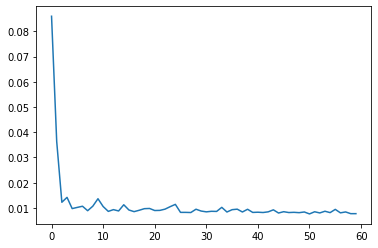

In [53]:
# printing the convergence log
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

<b>Saving the model</b>

In [54]:
model.save('my_rnn_model.h5')

<b>Predicting 12 steps forward</b>

In [55]:
# first batch
first_eval_batch = scaled_df_total[-12:]
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
first_eval_batch

array([[[0.42313009],
        [0.37475042],
        [0.497773  ],
        [0.31669482],
        [0.64352634],
        [0.34013208],
        [0.17723852],
        [0.03639994],
        [0.0060513 ],
        [0.07663953],
        [0.1227154 ],
        [0.29467056]]])

Predicting into the future for the entire test range

In [56]:
test_predictions = []
first_eval_batch = scaled_df_total[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
np.append(current_batch[:,1:,:], [[[99]]], axis=1)
print(current_batch.shape)
current_batch

(1, 12, 1)


array([[[0.42313009],
        [0.37475042],
        [0.497773  ],
        [0.31669482],
        [0.64352634],
        [0.34013208],
        [0.17723852],
        [0.03639994],
        [0.0060513 ],
        [0.07663953],
        [0.1227154 ],
        [0.29467056]]])

In [57]:
lstm_predictions = []
first_eval_batch = scaled_df_total[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    # getting a prediction 1 time stamp ahead
    # ([0] is for taking one number instead of [array])
    current_pred = model.predict(current_batch)[0]
    # storing the prediction
    lstm_predictions.append(current_pred) 
    # updating batch by including prediction and dropping a first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

lstm_predictions

[array([0.3614756], dtype=float32),
 array([0.4225248], dtype=float32),
 array([0.46753865], dtype=float32),
 array([0.49275446], dtype=float32),
 array([0.5294552], dtype=float32),
 array([0.45928484], dtype=float32),
 array([0.24883772], dtype=float32),
 array([0.0652905], dtype=float32),
 array([0.00071188], dtype=float32),
 array([0.02992881], dtype=float32),
 array([0.1127864], dtype=float32)]

<b>Inverse transformations and plotting the result<b>

In [58]:
# inverse transformation
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# writting all the forecasts in single data frame
index = fcast.index[:-1]
fcast_2 = pd.DataFrame(data=lstm_predictions,
                       columns=['LSTM Forecast'], index=index)
fcast_2['SARIMA(1,0,0)(1,0,1,12) Forecast'] = fcast
fcast_2.head(3)

,LSTM Forecast,"SARIMA(1,0,0)(1,0,1,12) Forecast"
2015-01-31,637.141887,860.106819
2015-02-28,736.514759,864.639840
2015-03-31,809.786045,974.545847


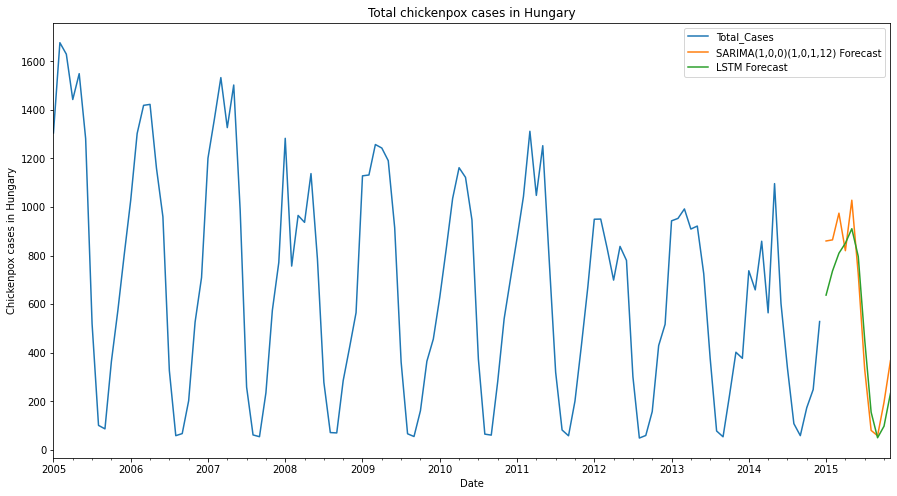

In [59]:
# plotting predictions against known values
title = 'Total chickenpox cases in Hungary'
ylabel = 'Chickenpox cases in Hungary'
xlabel = 'Date'

ax = df['Total_Cases'].plot(legend=True, figsize=(15,8), title=title)
fcast_2['SARIMA(1,0,0)(1,0,1,12) Forecast'].plot(legend=True)
fcast_2['LSTM Forecast'].plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Discussion: SARIMA and LSTM RNN demonstrated similar performance. RMSE of SARIMA is 140, LSTM - 165.